## Framework and Interfaces of this project

This project is using modular design paradigm, i.e., using functions instead of classes.

The whole project includes following vital components.

1. **Triming Component: This is the most important component of this project. It resolve how we choose and retain an area when a new tower is posed on the map.**
    
    **Function example: new_binary_map, new_tower_trimmed = commNetTrim(previous_binary_map, new_tower)**
    
    Inputs:
        1. previous_binary_map: 2-D numpy binary array.
        2. new_tower: a tuple of 4 integers, (left_up_x, left_up_y, width, height)
    
    Outputs:
        1. new_binary_map: 2-D numpy binary array
        2. new_tower_trimmed: a tuple of 4 integers, (left_up_x, left_up_y, width, height)

2. **Tower Generating Component: This component generates a random tower.**

    **Function example: new_tower = commNetGenTower(total_area)**

    Inputs:
        total_area: a tuple of 2 integers, (total_width, total_height).
    
    Outputs:
        new_tower: a tuple of 4 integers, (left_up_x, left_up_y, width, height)
    
3. **Drawing Component: This component is for printing a colorful map of trimmed towers given a sequence of trimmed tower areas.**
    
    **Function example: net_patches = commNetDraw(trimmed_towers, total_area)**
    
    Inputs: 
        1. trimmed_towers: A list of tuples of 4 integers(left_up_x, left_up_y, width, height), representing trimmed tower areas.
        2. total_area: a tuple of 2 integers, (total_width, total_height).
    
    Output:
        net_patches: A matplotlib figure with different colors representing areas covered by different towers.
        (Optional): A animation, that the plotting pauses once a new tower area is plotted.

4. **Gluing Component: Gluing the previous three components and construct a pipeline**

    **Function example: trimmed_towers, net_patches = commNetMain(total_area, given_towers)**
    
    Inputs: 
        1. given_towers: A list of tuples of 4 integers(left_up_x, left_up_y, width, height), representing given tower areas.
        2. total_area: a tuple of 2 integers, (total_width, total_height).
    
    Output:
        1. net_patches: A matplotlib figure with different colors representing areas covered by different towers.
        2. trimmed_towers: A list of tuples of 4 integers(left_up_x, left_up_y, width, height), representing trimmed tower areas.
        
5. **Utilities**:
    1. Generating total area
    2. Counting covered area
    3. Judge if all area is covered
    
6. **Testing Components**: 
    1. Function to test problem 1: Given an overall desired coverage footprint and a sequence of n communications towers, what is the resulting resolved coverage?
    2. Function to test problem 2: What is the total area of coverage relative to the desired total coverage area of the original footprint? That is, are there any gaps in coverage?
    3. Function to test problem 3: On average, how many communications towers are required before full coverage is obtained?

### Triming Component:

#### This is the most important component of this project. It resolve how we choose and retain an area when a new tower is posed on the map.

    **Function example: new_binary_map, new_tower_trimmed = commNetTrim(previous_binary_map, new_tower)**
    
    Inputs:
        1. previous_binary_map: 2-D numpy binary array.
        2. new_tower: a tuple of 4 integers, (left_up_x, left_up_y, width, height)
    
    Outputs:
        1. new_binary_map: 2-D numpy binary array
        2. new_tower_trimmed: a tuple of 4 integers, (left_up_x, left_up_y, width, height)



In [5]:
import numpy as np
import matplotlib.pyplot as plt

### Tower Generating Component: This component generates a random tower.

    **Function example: new_tower = commNetGenTower(total_area)**

    Inputs:
        total_area: a tuple of 2 integers, (total_width, total_height).
    
    Outputs:
        new_tower: a tuple of 4 integers, (left_up_x, left_up_y, width, height)

In [6]:
def commNetGenTower(total_area):
    """
    Generates a random tower.
    
    Inputs:
    total_area: a tuple of 2 integers, (total_height, total_height).

    Outputs:
    new_tower: a tuple of 4 integers, (left_up_x, left_up_y, height, height)
    """
    total_width, total_height = total_area
    left_up_x = np.random.randint(0, total_width)
    left_up_y = np.random.randint(0, total_height)
    width = np.random.randint(1, total_width-left_up_x+1)
    height = np.random.randint(1, total_height-left_up_y+1)
    new_tower = (left_up_x, left_up_y, width, height)
    
    return new_tower

In [7]:
total_area = (10, 15)

In [8]:
for i in range(3):
    print commNetGenTower(total_area)

(9, 7, 1, 4)
(5, 13, 2, 2)
(4, 14, 1, 1)


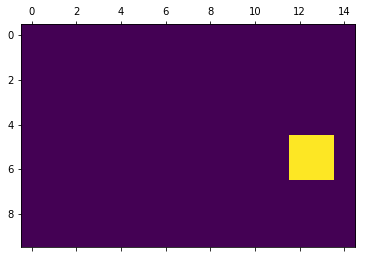

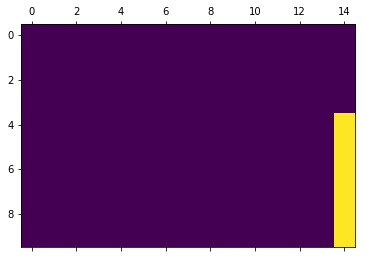

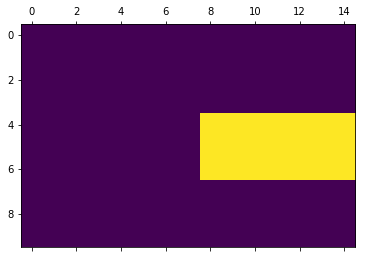

In [9]:
# Test commNetGenTower(total_area)
total_area = (10, 15)
for i in range(3):
    new_tower = commNetGenTower(total_area)
    (left_up_x, left_up_y, width, height) = new_tower
    old_map = np.zeros(total_area)
    new_map = np.copy(old_map)
    new_map[left_up_x : left_up_x+width, left_up_y : left_up_y+height] += 1 
    plt.matshow(new_map)

### **Triming Component: This is the most important component of this project. It resolve how we choose and retain an area when a new tower is posed on the map.**
    
    **Function example: new_binary_map, new_tower_trimmed = commNetTrim(previous_binary_map, new_tower)**
    
    Inputs:
        1. previous_binary_map: 2-D numpy binary array.
        2. new_tower: a tuple of 4 integers, (left_up_x, left_up_y, width, height)
    
    Outputs:
        1. new_binary_map: 2-D numpy binary array
        2. new_tower_trimmed: a tuple of 4 integers, (left_up_x, left_up_y, width, height)

#### In order to implement an efficient trimming, I take three steps:
    1. Write a subroutine *commNetLargeRectHist()* to calculate the largest rectangle in a histogram;
    2. Use the current tower area to minus overlapping area, resulting in a binary matrix of 0(occupied)/1(unoccupied);
    3. In this binary matrix, use *commNetLargeRectHist()* to find the possible largest rectangle, and regard this rectangle as trimmed area of this new tower


##### step 1
In the following function, I am implementing an algorithm that returns the largest area in a histogram. The time complexity of this algorithm is O(n). This implementation is inspired by the descritption of the algorithm in following link: https://www.geeksforgeeks.org/largest-rectangle-under-histogram/. I modified the original algorithm (add a "zero" bar at the beginning and at the end) in order to give a more general result and avoid discussing corner cases.

In [10]:
def commNetLargeRectHist(alist):
    """
    Implementation of an algorithm that returns the largest area in a histogram.
    
    Params:
    -------
    alist, a list of intergers representing a histogram.
    
    Return:
    -------
    left_index: int, left index(not included) of the largest rectangle;
    right_index: int, right index(not included) of the largest rectangle;
    height: int, height of the largest rectangle;
    largest_area: int, area of the largest rectangle.
    """
    
    full_list = [0] + alist + [0] # pad the original histogram with two "zero" bars, for consistency in algorithm
    index_list = list(range(len(full_list)))

    stk = []
    stk.append(0) # initialize the stack of indices, and put in the first element in padded list.
    saved_rects = []
    largest_area = 0 # initialize the largest area to 0.

    i = 1 # initialize the pointer to position 1, i.e. the beginning of histogram

    while stk[-1]!=0 or full_list[i]!=0: 
        # Stop condition: the top of stack is zero AND we have reached the end of histogram

        if full_list[i] >= full_list[stk[-1]]: # If this bar is larger than/equal to the top bar in the stack
            stk.append(i) # put this bar in stack
            i += 1 # evaluate the next bar in histogram

        else: # If this bar is smaller than the top bar in the stack
            this_height = full_list[stk.pop()] # pop the top bar in the stack, and use its value as height of rectangle
            this_left_index = stk[-1] # left and right indices are used to calculate width of rectangle
            this_right_index = i
            this_area = (this_right_index - this_left_index - 1) * this_height
            saved_rects.append((this_height, this_left_index, this_right_index, this_area))
            if this_area > largest_area: # store data if this area is the largest so far
                largest_area = this_area
                left_index = this_left_index
                right_index = this_right_index
                height = this_height
    print saved_rects

    return {'largest_area': largest_area, 'left_index': left_index, 'right_index': right_index, 'height': height}

In [11]:
d = commNetLargeRectHist([6, 2, 5, 4, 5, 1, 6])

[(6, 0, 2, 6), (5, 2, 4, 5), (5, 4, 6, 5), (4, 2, 6, 12), (2, 0, 6, 10), (6, 6, 8, 6), (1, 0, 8, 7)]


In [12]:
d

{'height': 4, 'largest_area': 12, 'left_index': 2, 'right_index': 6}

##### step 2
In the following function, I subtract the overlapping area from the new tower, resulting in a binary matrix of 0(occupied)/1(unoccupied);

In [3]:
def commNetSubtractOverlap(previous_binary_map, new_tower):
    """
    Subtract the overlapping area from the new tower.
    
    Params:
    -------
    1. previous_binary_map: 2-D numpy binary array. "1" is positions covered by previous towers, "0" is positions
    not covered by previous towers.
    2. new_tower: a tuple of 4 integers, (left_up_x, left_up_y, width, height)
    
    Return:
    -------
    remain_area: A binary 2-D numpy array of 0(occupied)/1(unoccupied), the same size as new tower area.
    """
    
    (left_up_x, left_up_y, width, height) = new_tower
    remain_area = np.ones((width, height)) - previous_binary_map[left_up_x : left_up_x+width, left_up_y : left_up_y+height]
    
    return remain_area


In [112]:
previous_towers = np.eye(8)
new_tower = commNetGenTower((8, 8))
ra = commNetSubtractOverlap(previous_towers, new_tower)

print previous_towers
print new_tower
print ra

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
(5, 5, 3, 2)
[[0. 1.]
 [1. 0.]
 [1. 1.]]


##### step 3
In the following function, I use *commNetLargeRectHist()* to find the possible largest rectangle in the *remain_area* returned by *commNetSubtractOverlap()*, and regard this rectangle as trimmed area of this new tower.

In [ ]:
def commNetSubtractOverlap(remain_area, new_tower):
    """
    Subtract the overlapping area from the new tower.
    
    Params:
    -------
    1. previous_binary_map: 2-D numpy binary array. "1" is positions covered by previous towers, "0" is positions
    not covered by previous towers.
    2. new_tower: a tuple of 4 integers, (left_up_x, left_up_y, width, height)
    
    Return:
    -------
    remain_area: A binary 2-D numpy array of 0(occupied)/1(unoccupied), the same size as new tower area.
    """
    
    (left_up_x, left_up_y, width, height) = new_tower
    remain_area = np.ones((width, height)) - previous_binary_map[left_up_x : left_up_x+width, left_up_y : left_up_y+height]
    
    return remain_area